In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Input: 784 pixels → Hidden: 128 neurons
        self.fc2 = nn.Linear(128, 64)       # Hidden: 128 → Hidden: 64 neurons
        self.fc3 = nn.Linear(64, 10)        # Hidden: 64 → Output: 10 (digits 0-9)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten input image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation (logits for CrossEntropyLoss)
        return x

# Initialize model
model = MNIST_Net()
model.load_state_dict(torch.load("model_weights.pth"))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



MNIST_Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [3]:
# import torch.optim as optim

# # Define loss function & optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# epochs = 5
# for epoch in range(epochs):
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)  # Move data to GPU

#         optimizer.zero_grad()  # Reset gradients
#         outputs = model(images)  # Forward pass
#         loss = criterion(outputs, labels)  # Compute loss
#         loss.backward()  # Backpropagation
#         optimizer.step()  # Update weights

#     print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# print("Training complete!")

# # Save the model's state_dict
# torch.save(model.state_dict(), "./model_weights.pth")


In [4]:
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.10%


In [5]:
total_weights = sum(p.numel() for name, p in model.named_parameters() if "weight" in name)
total_biases = sum(p.numel() for name, p in model.named_parameters() if "bias" in name)

print(f"Total Weights: {total_weights}")
print(f"Total Biases: {total_biases}")
print(f"Total Parameters: {total_weights + total_biases}")


Total Weights: 109184
Total Biases: 202
Total Parameters: 109386


109184


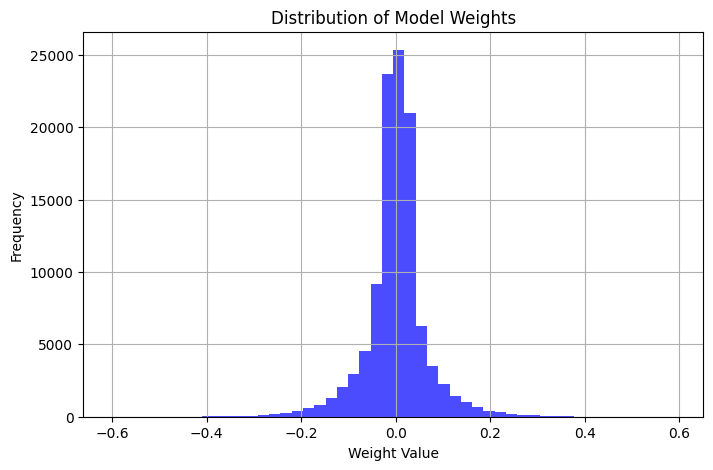

In [6]:
import matplotlib.pyplot as plt

# Get all weights as a flattened tensor
all_weights = torch.cat([param.view(-1) for name, param in model.named_parameters() if "weight" in name])
print(len(all_weights))

# Convert to NumPy for plotting
all_weights = all_weights.detach().cpu().numpy()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_weights, bins=50, alpha=0.7, color="blue")
plt.title("Distribution of Model Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


976


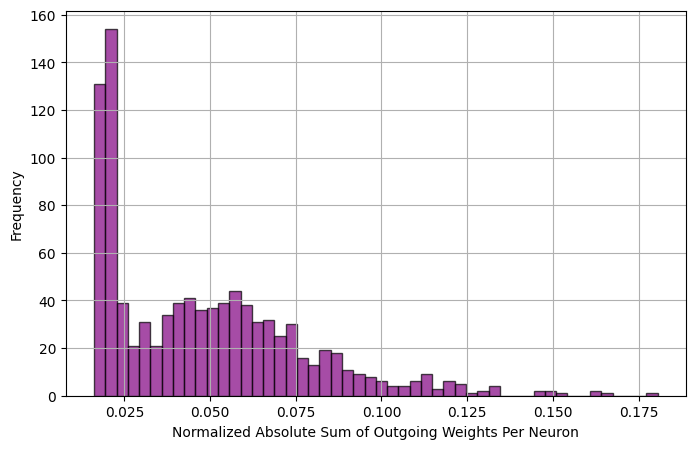

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Compute absolute sum of outgoing weights per neuron and normalize by the number of weights
fc1_outgoing = torch.sum(torch.abs(model.fc1.weight), dim=0) / model.fc1.weight.size(0)
fc2_outgoing = torch.sum(torch.abs(model.fc2.weight), dim=0) / model.fc2.weight.size(0)
fc3_outgoing = torch.sum(torch.abs(model.fc3.weight), dim=0) / model.fc3.weight.size(0)

# Combine all values
all_outgoing_sums = np.concatenate([fc1_outgoing.detach().cpu().numpy(), 
                                    fc2_outgoing.detach().cpu().numpy(), 
                                    fc3_outgoing.detach().cpu().numpy()])  # Total: 976 neurons
print(len(all_outgoing_sums))

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(all_outgoing_sums, bins=50, alpha=0.7, color="purple", edgecolor="black")
plt.xlabel("Normalized Absolute Sum of Outgoing Weights Per Neuron")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
